In [545]:
import numpy as np
import pandas as pd
import matplotlib as plt
import datetime
#turns seconds into a string format ffmpeg uses
def seconds_formatter(sec):
    x = "0" + str(datetime.timedelta(seconds=sec))[:-3]
    return x
seconds_formatter(175.305)

'00:02:55.305'

In [546]:
df = pd.read_hdf(r"C:\Users\vjj14\Desktop\DeepLabCut\goprofrontview-vj-2019-06-17\videos\gpDeepCut_resnet50_goprofrontviewJun17shuffle1_30001.h5")
#remove extra level "scorer"
df.columns = df.columns.droplevel()
df.describe()

bodyparts       leftEar                                  rightEar  \
coords                x             y    likelihood             x   
count      24320.000000  24320.000000  24320.000000  24320.000000   
mean         418.129470    104.092916      0.819854    342.438231   
std           59.484658     55.269955      0.345757     61.201473   
min           -0.232820      0.058952      0.000652      1.185614   
25%          410.203378     75.918766      0.963633    317.790530   
50%          431.752412    109.551635      0.999844    332.283849   
75%          443.193016    141.584548      0.999973    346.850670   
max          651.580333    398.199630      0.999999    609.912476   

bodyparts                                      Nose                \
coords                y    likelihood             x             y   
count      24320.000000  24320.000000  24320.000000  24320.000000   
mean         101.684238      0.801598    375.327111    208.523040   
std           58.679316      0.350441     59.976627     70.090319   
min           -2.496538      0.001448      0.344874     18.644475   
25%           64.836136      0.799568    366.916633    149.775522   
50%          103.500209      0.999885    382.856600    222.712812   
75%          142.310630      0.999981    389.395545    261.157506   
max          346.226936      0.999999    623.018394    397.013597   

bodyparts                    leftHand      ...          rightHand  \
coords       likelihood             x      ...         likelihood   
count      24320.000000  24320.000000      ...       24320.000000   
mean           0.789948    401.102718      ...           0.459706   
std            0.335402     42.124632      ...           0.409989   
min            0.002590     64.313986      ...           0.001246   
25%            0.663167    382.997393      ...           0.045521   
50%            0.996328    403.306821      ...           0.325276   
75%            0.999806    426.271711      ...           0.952850   
max            0.999998    652.821492      ...           0.999980   

bodyparts      leftFoot                                 rightFoot  \
coords                x             y    likelihood             x   
count      24320.000000  24320.000000  24320.000000  24320.000000   
mean         400.000369    211.809658      0.563731    325.880319   
std          106.976893     68.213118      0.431094     36.197824   
min           70.790897      4.613057      0.002174      1.576407   
25%          395.883299    152.843292      0.087321    305.209249   
50%          438.449283    214.538742      0.681825    319.431005   
75%          455.452176    224.842714      0.999839    335.237931   
max          654.890787    395.073073      0.999997    646.668256   

bodyparts                                    pellet                \
coords                y    likelihood             x             y   
count      24320.000000  24320.000000  24320.000000  24320.000000   
mean         193.638297      0.801919    391.551464    295.535599   
std           42.793461      0.327147     38.246815     62.200636   
min            1.647910      0.003355      1.279912      0.627747   
25%          152.980904      0.679855    392.289892    267.040393   
50%          211.355771      0.997711    395.490041    325.472089   
75%          224.876223      0.999907    397.825792    335.043683   
max          396.876828      0.999999    641.452611    395.651502   

bodyparts                
coords       likelihood  
count      24320.000000  
mean           0.634827  
std            0.460287  
min            0.001884  
25%            0.025175  
50%            0.999050  
75%            0.999830  
max            0.999988  

[8 rows x 24 columns]

In [547]:
def frame_to_time(frame):
    total_seconds = (frame/24320)*202
    return round(total_seconds, 3)
def time_to_frame(time):
    return 24320*(time/202)
def dist_from_dispenser(x, y):
    return ((x-390)**2 + (y-341)**2)**0.5

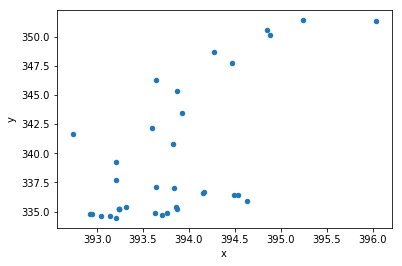

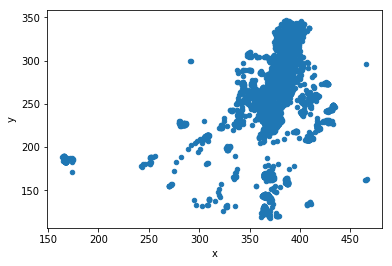

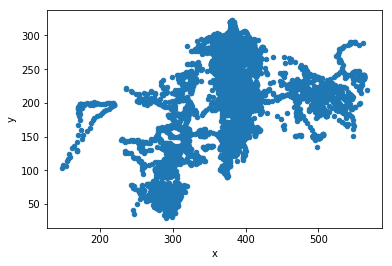

In [548]:
labels = {key: df[df[key, 'likelihood'] > 0.9][key] for key in list(df.columns.levels[0])}
{labels[key].insert(0, "frame", labels[key].index, True) for key in labels.keys()}
{labels[key].insert(0, "time", labels[key]['frame'].map(frame_to_time), True) for key in labels.keys()}
leftEar = labels['leftEar']
rightEar = labels['rightEar']
nose = labels['Nose']
leftHand = labels['leftHand']
rightHand = labels['rightHand']
leftFoot = labels['leftFoot']
rightFoot = labels['rightFoot']
pellet = labels['pellet']
pellet[(pellet['time'] > 39) & (pellet['time'] < 40)].plot(kind='scatter', x='x', y='y')
rightHand.plot(kind='scatter', x='x', y='y')
nose.plot(kind='scatter', x='x', y='y')

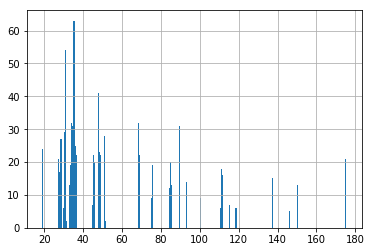

In [549]:
#add distance from dispenser column to the hand dataframe
rightHand['d_from_dispenser'] = rightHand.apply(lambda row: dist_from_dispenser(x = row['x'], y = row['y']), axis=1)
hand_reach2 = rightHand[rightHand['d_from_dispenser'] < 35]
hand_reach2['time'].hist(bins=300)

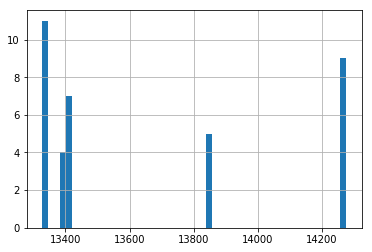

In [550]:
hand_reach2 = rightHand[(rightHand['d_from_dispenser'] < 30)& (rightHand['time'] < 120) & (rightHand['time'] > 109)]
hand_reach2['frame'].hist(bins=50)

## Determining when the mouse is reaching
### First Method: Basing it off of the distance from dispenser*
*where the pellet is SUPPPOSED to be, currently hard coded pixel coordinates.

In [625]:
hand_reach2 = rightHand[rightHand['d_from_dispenser'] < 40]
def get_reaches():
    """Returns: List of Tuples, where each tuple is a reach, 
    1st element of tuple is start time, 2nd element of tuple is the duration
    
    Given frames where hand is within a set radius, loop through, 
    bunch approximately consecutive frames (within x frames of each other)
    as a single reach. Filter out 'reaches' that are impossibly short.
    """
    reaches = []
    last_frame = hand_reach2['frame'].values[0]
    consec_frames_ct = 1 #number of consecutive frames
    first_frame_of_reach = last_frame
    for frame in hand_reach2['frame'].values:
        if (frame - last_frame < 10):
            consec_frames_ct += 1
        else:
            reaches.append((first_frame_of_reach, consec_frames_ct))
            consec_frames_ct = 1
            first_frame_of_reach = frame
        last_frame = frame
    reaches.append((first_frame_of_reach, consec_frames_ct))
    
    #filter out false positives: reaches that only lasted 3 or less frames
    reaches2 = [x for x in reaches if x[1] >= 3]
    reaches2_time = [(frame_to_time(x[0]), frame_to_time(x[1])) for x in reaches2]
    return reaches2_time
get_reaches()

[(18.904, 0.208),
 (26.778, 0.033),
 (27.401, 0.183),
 (28.157, 0.266),
 (28.722, 0.324),
 (30.333, 0.291),
 (30.981, 0.473),
 (33.406, 0.266),
 (34.088, 0.266),
 (34.827, 0.988),
 (36.098, 0.224),
 (44.935, 0.241),
 (45.658, 0.166),
 (47.701, 0.341),
 (48.457, 0.374),
 (51.023, 0.249),
 (68.499, 0.266),
 (69.138, 0.199),
 (75.102, 0.108),
 (75.592, 0.174),
 (84.546, 0.216),
 (85.119, 0.158),
 (89.604, 0.257),
 (93.118, 0.141),
 (100.452, 0.133),
 (105.618, 0.042),
 (110.676, 0.208),
 (111.274, 0.133),
 (114.962, 0.1),
 (118.509, 0.158),
 (137.488, 0.15),
 (145.985, 0.066),
 (149.897, 0.174),
 (175.238, 0.199)]

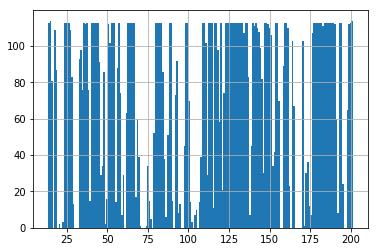

In [590]:
#add distance from dispenser column to the hand dataframe
pellet['d_from_dispenser'] = pellet.apply(lambda row: dist_from_dispenser(x = row['x'], y = row['y']), axis=1)
pellet2 = pellet[pellet['d_from_dispenser'] < 20]
pellet2['time'].hist(bins=200)

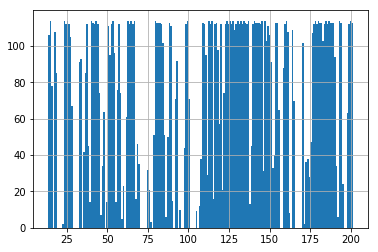

In [554]:
pellet[pellet['likelihood']>0.99]['time'].hist(bins=200)

### Second Method: Using (averaged) likelihood
Based off the observation that pellets in position have much higher likelihoods. I think that this is a bad idea and may not generalize, but the way I did it (averaging frames around it) is an alternate and possibly better way to deal with outliers.

C:\Users\vjj14\.conda\envs\dlc-windowsGPU\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\vjj14\.conda\envs\dlc-windowsGPU\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\vjj14\.conda\envs\dlc-windowsGPU\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


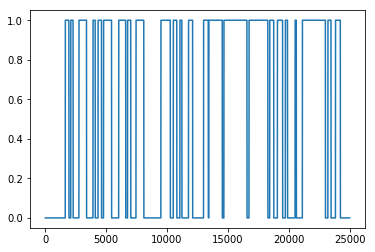

In [559]:
temp = array.copy()

for i in range(50, len(array)):
    temp[i] = np.mean(array[i-100:i+100])
#     print(np.mean(array[i-50:i+50]))
array = temp
# np.histogram(array, bins=200, range=(0, 25000))
plt.pyplot.plot((array > 0.5))

1631


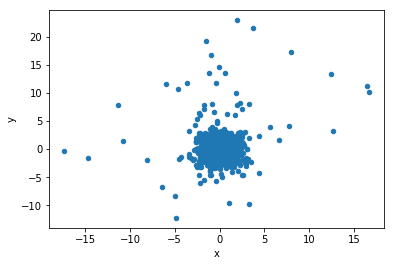

In [601]:
# c999 = pellet[pellet['likelihood'] > 0.999]
# c999.plot(kind='scatter', x='x', y='y')
c99 = pellet[pellet['likelihood'] > 0.99]
# c99.plot(kind='scatter', x='x', y='y')
# c95 = pellet[pellet['likelihood'] > 0.95]
# c95.plot(kind='scatter', x='x', y='y')
# c90 = pellet[pellet['likelihood'] > 0.90]
# c90.plot(kind='scatter', x='x', y='y')
subset = c99.diff().reset_index()
# subset[(subset['y'] < 1) & (subset['y'] > -1)].plot(kind='scatter', x='index', y='y')
# subset.diff()
# subset['index'].hist(bins=500)
print(min(subset['index']))
max(subset['index'])
subset.plot(kind = 'scatter', x='x', y='y')

In [627]:
array = np.zeros(25000)
for frame in c99['frame']:
    array[frame] = 1.0
temp = array.copy()
for i in range(50, len(array)):
    temp[i] = np.mean(array[i-50:i+50])
#     print(np.mean(array[i-50:i+50]))
array = temp
# np.histogram(array, bins=200, range=(0, 25000))
def experiment():
    results = []
    temp = array > 0.5
    curr_start = 0
    curr_len = 0
    for i in range(len(temp)):
        if temp[i] and curr_len == 0:
            curr_start = i
            curr_len = 1
        elif temp[i]:
            curr_len += 1
        elif not temp[i] and curr_len != 0:
            results.append((curr_start, curr_len))
            curr_len = 0
    
    #filter out false positives: 'reaches' that lasted for less than 0.1 seconds
    results2 = [x for x in results if x[1] > 12] #assuming 120 fps
    results2_time = [(frame_to_time(x[0]), frame_to_time(x[1])) for x in results2]
    return results2_time
print(experiment())
pellet_times

[(13.613, 2.467), (17.351, 1.595), (22.924, 5.266), (32.509, 1.62), (36.305, 2.018), (39.719, 5.415), (47.07, 0.806), (50.051, 4.867), (56.023, 2.251), (61.854, 5.332), (68.549, 0.664), (75.293, 0.374), (78.831, 6.479), (87.295, 2.334), (91.805, 1.346), (97.669, 2.824), (108.043, 3.281), (112.022, 2.99), (115.826, 2.724), (119.148, 1.57), (121.823, 15.731), (138.958, 7.068), (146.707, 5.083), (153.078, 2.741), (158.253, 3.621), (163.76, 1.478), (170.388, 0.856), (172.813, 0.606), (174.765, 0.615), (175.986, 15.158), (192.772, 2.126), (197.938, 3.331)]


[(13.547, 2.558),
 (17.343, 1.454),
 (22.916, 5.15),
 (28.448, 0.158),
 (32.493, 1.611),
 (39.711, 5.582),
 (45.699, 0.116),
 (47.061, 0.864),
 (50.018, 1.08),
 (55.907, 2.284),
 (59.686, 0.183),
 (61.838, 5.357),
 (68.432, 0.772),
 (97.653, 0.116),
 (107.138, 0.116),
 (108.027, 1.993),
 (112.014, 1.62),
 (115.818, 1.802),
 (119.132, 1.595),
 (121.815, 1.885),
 (126.64, 4.768),
 (138.95, 1.703),
 (146.691, 1.454),
 (148.975, 1.495),
 (158.211, 0.116),
 (159.216, 2.002),
 (175.978, 1.62),
 (182.763, 5.922),
 (189.209, 2.193)]

## Compile Hand Reaches into Video

In [ ]:
#Open up new batch file
project_name = "goprofrontview"
bat_file= r"C:\Users\vjj14\Desktop\DeepLabCut\goprofrontview-vj-2019-06-17\videos\{}_create_videos.bat".format(project_name)
script_writer= open(bat_file,"w")

#write series of shell commands to create videos for each attempt, connected by '&&' for the batch file
reaches = get_reaches()
vids = []
for tpl in reaches:
    start_time = seconds_formatter(max(0, tpl[0] - 2))
    cmd = "ffmpeg -i gp.mp4 -ss {0} -t {1} -c copy {2}.mp4".format(start_time, 2.5 + tpl[1], np.round(tpl[0], 3))
    vids.append(str(np.round(tpl[0], 3)) + ".mp4")
    script_writer.write(cmd + " && ")
script_writer.close()

#open and write a list of videos to concatenate (.txt file) for ffmpeg to use
list_file = r"C:\Users\vjj14\Desktop\DeepLabCut\goprofrontview-vj-2019-06-17\videos\{}_video_list.txt".format(project_name)
list_writer = open(list_file, "w+")
for v in vids:
    list_writer.write('file ' + "\'" + r"C:\Users\vjj14\Desktop\DeepLabCut\goprofrontview-vj-2019-06-17\videos\{}".format(v) + "\'\n")
list_writer.close()

#open batch file again and write command to produce a concatenated video, the final product
script_writer = open(bat_file, "a+")
script_writer.write("ffmpeg -f concat -safe 0 -i {0} -c copy output.mp4".format(list_file))
script_writer.close()

In [565]:
np.argwhere(array > 0.5)
pellet2 = pellet[pellet['likelihood'] > 0.99]
def get_pellet_times():
    pellet2 = pellet[(pellet['d_from_dispenser'] < 12)]
    pellets = []
    last_frame = pellet2['frame'].values[0]
    consec_frames_ct = 1 #number of consecutive frames
    first_frame_of_pellet = last_frame
    for frame in pellet2['frame'].values:
        if (frame - last_frame < 18):
            consec_frames_ct += 1
        else:
            pellets.append((first_frame_of_pellet, consec_frames_ct))
            consec_frames_ct = 1
            first_frame_of_pellet = frame
        last_frame = frame
    pellets.append((first_frame_of_pellet, consec_frames_ct))
    
    #filter out false positives: 'reaches' that lasted for less than 0.1 seconds
    pellet2 = [x for x in pellets if x[1] > 12] #assuming 120 fps
    pellets2_time = [(frame_to_time(x[0]), frame_to_time(x[1])) for x in pellet2]
    return pellets2_time
pellet_times = get_pellet_times()

C:\Users\vjj14\.conda\envs\dlc-windowsGPU\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [589]:
for r in reaches:
    print(r)
    print(binary_search(pellet_times, r))

(18.904, 0.208)
No Pellet There[(17.343, 1.454)]
(26.778, 0.033)
(22.916, 5.15)
(27.401, 0.183)
(22.916, 5.15)
(28.157, 0.266)
No Pellet There[(22.916, 5.15)]
(28.722, 0.324)
No Pellet There[(28.448, 0.158)]
(30.333, 0.291)
No Pellet There[(28.448, 0.158)]
(30.981, 0.473)
No Pellet There[(28.448, 0.158)]
(33.406, 0.266)
(32.493, 1.611)
(34.088, 0.266)
(32.493, 1.611)
(34.827, 0.988)
No Pellet There[(32.493, 1.611)]
(36.098, 0.224)
No Pellet There[(32.493, 1.611)]
(44.935, 0.241)
(39.711, 5.582)
(45.658, 0.166)
No Pellet There[(39.711, 5.582)]
(47.701, 0.341)
(47.061, 0.864)
(48.457, 0.374)
No Pellet There[(47.061, 0.864)]
(51.023, 0.249)
(50.018, 1.08)
(68.499, 0.266)
(68.432, 0.772)
(69.138, 0.199)
(68.432, 0.772)
(75.102, 0.108)
No Pellet There[(68.432, 0.772)]
(75.592, 0.174)
No Pellet There[(68.432, 0.772)]
(84.546, 0.216)
No Pellet There[(68.432, 0.772)]
(85.119, 0.158)
No Pellet There[(68.432, 0.772)]
(89.604, 0.257)
No Pellet There[(68.432, 0.772)]
(93.118, 0.141)
No Pellet Ther

In [588]:
def binary_search(p_times, r_time):
    if len(p_times) == 1:
        if (r_time[0] < p_times[0][0]) or (r_time[0] > p_times[0][0] + p_times[0][1]):
            return "No Pellet There" + str(p_times)
        return p_times[0]
    elif r_time[0] > p_times[len(p_times)//2][0]:
        return binary_search(p_times[len(p_times)//2:], r_time)
    else:
        return binary_search(p_times[:len(p_times)//2], r_time)

In [ ]:
print(frame_to_time(13300))
time_to_frame(100)